In [1]:
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from astropy.coordinates import AltAz, angular_separation
from scipy.spatial.transform import Rotation
from scipy.signal import argrelextrema
from scipy.interpolate import interp1d

In [2]:
# from https://www.ngdc.noaa.gov/geomag/calculators/magcalc.shtml
# for Nov 29, 2021 and 10 km a.s.l.:

mag_declination = -4.8419 * u.deg  # deg (N-E-S-W  Negative is west of north) 
mag_inclination = -37.3594 * u.deg # deg (from horizontal, <0 is downwards)

bfield = AltAz(alt=mag_inclination, az=mag_declination)

In [3]:
LP_lat = 28.7636 * u.deg
LP_lon = -17.894728 * u.deg

# North pole from La Palma, az (from N) and zenith:
north_az = 0 * u.deg
north_zen = 90 * u.deg - LP_lat

In [4]:
x, y = np.meshgrid(np.linspace(-10,370,190), np.linspace(0,90,180))

In [5]:
bfield

<AltAz Coordinate (obstime=None, location=None, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (355.1581, -37.3594)>

In [6]:
# Convert bfield coordinates. Azimuth is astronomical azimuth, from N, clockwise
# FROM az-from-north-eastwards, altitude 
# TO   az-from-north-eastwards, zenith:

az_bfield = bfield.az
zen_bfield = 90*u.deg - bfield.alt

print(az_bfield, zen_bfield)

355d09m29.16s 127d21m33.84s


In [7]:
# zd, az to azimuthal equidistant coordinates.
# Everything assumed in degrees:
def zd_az_to_azimuthal_equidistant(zd, az):
    # map centered at zenith
    lat = np.deg2rad(90-zd)
    long = np.deg2rad(az)

    c = np.arccos(np.sin(lat))
    k = c / np.sin(c)
    x = k * np.cos(lat)*np.sin(long)
    y = -k * np.cos(lat)*np.cos(long)
    
    # Change sign of x and y for sky "as seen" (with N up, W is right):
    return -np.rad2deg(x), -np.rad2deg(y)

/tmp/ipykernel_27539/4256728667.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'cos_zenith': np.cos(np.deg2rad(10)), 'sin_delta': 0.77}, ignore_index=True)


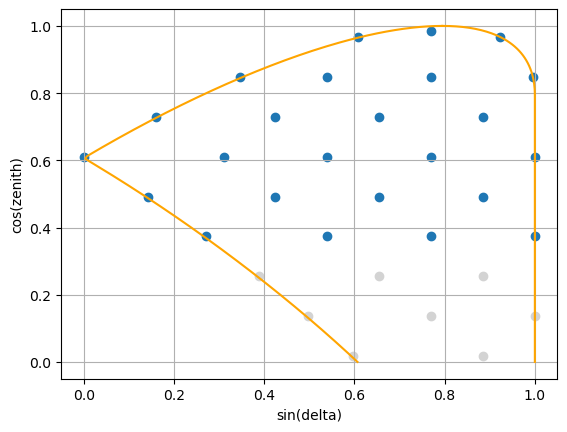

In [8]:
# MC pointing grid from Chaitanya:
grid = pd.read_hdf('MC_pointing_grid.h5', 'MC_pointing_grid')

# Add one extra point at 10 degree zenith angle, following discussins on 20211203 call
grid = grid.append({'cos_zenith': np.cos(np.deg2rad(10)), 'sin_delta': 0.77}, ignore_index=True)

mask = np.rad2deg(np.arccos(grid['cos_zenith']))<70
plt.scatter (grid['sin_delta'][mask], grid['cos_zenith'][mask])
plt.scatter (grid['sin_delta'][~mask], grid['cos_zenith'][~mask], color='lightgrey')

#Draw physics limit
zens = np.sort(np.unique(y))
azs  = np.sort(np.unique(x))
minsindelta = []
maxsindelta = []
for zen in zens:
    sindeltas = np.sin(angular_separation(az_bfield, 90*u.deg-zen_bfield, 
                                          azs*u.deg, 90*u.deg - zen*u.deg))
    minsindelta.append(np.min(sindeltas))
    maxsindelta.append(np.max(sindeltas))

minsindelta = np.array(minsindelta)
plt.plot(minsindelta, np.cos(zens*u.deg), color='orange')
plt.plot(maxsindelta, np.cos(zens*u.deg), color='orange')

plt.grid()
plt.xlabel('sin(delta)')
plt.ylabel('cos(zenith)')
plt.show()
cosz = sorted(grid['cos_zenith'])
#for i, a in enumerate(cosz):
#    b = grid['sin_delta'][i]
#    print(f'{a:.3f}, {b:.3f}')
    

    

In [9]:
north_versor = np.array([np.sin(north_zen).value, 0, np.cos(north_zen).value])
north_versor

array([0.87661256, 0.        , 0.48119686])

In [10]:
def find_source_path(source_dec, max_time_from_culmination, max_zenith=90) : 

    source_dec *= u.deg

    #north_versor = np.array([(np.sin(north_zen)*np.cos(north_az)).value,
    #                     (np.sin(north_zen)*np.sin(north_az)).value,
    #                     (np.cos(north_zen)).value])

    north_versor = np.array([np.sin(north_zen).value, 0, np.cos(north_zen).value])

    
    source_culmination_zen = abs(LP_lat - source_dec)
    source_culmination_az =  180 * u.deg

    if LP_lat < source_dec:
        source_culmination_az = 0 * u.deg

    # Source versor at culmination:
    source_culmination_versor = np.array([(np.sin(source_culmination_zen)*
                                          np.cos(source_culmination_az)).value,
                                         (np.sin(source_culmination_zen)*
                                          np.sin(source_culmination_az)).value,
                                         (np.cos(source_culmination_zen)).value])

    n_steps = 501
    tmin = -max_time_from_culmination
    tmax =  max_time_from_culmination

    src_az = []
    src_zen = []
    time = np.linspace(tmin, tmax, n_steps)

    R = Rotation.from_rotvec(np.pi / 12 * 0 * north_versor)
    rotated = R.apply(source_culmination_versor)
    
    for i, t in enumerate(time):

        R = Rotation.from_rotvec(np.pi / 12 * t * north_versor)
        rotated = R.apply(source_culmination_versor)
        
        zen = np.rad2deg(np.arccos(rotated[2]))
        if zen > max_zenith:
            src_zen.append(np.nan)
            src_az.append(np.nan)
            time[i] = np.nan
            continue

        src_zen.append(zen)

        az  = np.rad2deg(np.arctan2(rotated[1], rotated[0]))
        if az < 0:
            az += 360
        src_az.append(az)

    time = np.array(time)
    src_az = np.array(src_az)
    src_zen = np.array(src_zen)
        
    mask = ~np.isnan(src_az)

    return src_az[mask], src_zen[mask], time[mask]
    

def plot_source_path(src_az, src_zen, time, interval=np.nan,
                     azimuthal_projection=False):

    n_steps = len(src_az)
    
    if azimuthal_projection:
        srcx, srcy = zd_az_to_azimuthal_equidistant(np.array(src_zen), np.array(src_az))
    else:
        srcx = src_az
        srcy = src_zen
    
    if azimuthal_projection:
        plt.plot(srcx, srcy, color='k', linewidth=1, marker='')
    else:
        plt.plot(srcx[:int(n_steps/2)], srcy[:int(n_steps/2)], color='k', linewidth=1, marker='')
        plt.plot(srcx[int(n_steps/2)+1:], srcy[int(n_steps/2)+1:], color='k', linewidth=1, marker='')

    if np.isnan(interval):
        return
        
    # Now find and plot the points at intervals "interval" hours around culmination:
    interp_az_vs_t = interp1d(time, src_az, fill_value="extrapolate")
    interp_zen_vs_t = interp1d(time, src_zen, fill_value="extrapolate")
    tt = [0]
    i = 0
    while(True):
        i += 1
        if i*interval > np.max(time):
            break
        tt.append(i*interval)
        tt.append(-i*interval)

    tt = np.sort(tt)
    src_az = interp_az_vs_t(tt)
    src_zen = interp_zen_vs_t(tt)

    if azimuthal_projection:
        srcx, srcy = zd_az_to_azimuthal_equidistant(np.array(src_zen), np.array(src_az))
    else:
        srcx = src_az
        srcy = src_zen
        
        
def plot_source_path2(src_az, src_zen, time, interval=np.nan,
                     azimuthal_projection=False):

    n_steps = len(src_az)
    
    if azimuthal_projection:
        srcx, srcy = zd_az_to_azimuthal_equidistant(np.array(src_zen), np.array(src_az))
    else:
        srcx = src_az
        srcy = src_zen
    
    if azimuthal_projection:
        plt.plot(srcx, srcy, color='k', linewidth=1, marker='', alpha=0.5)
    else:
        plt.plot(srcx[:int(n_steps/2)], srcy[:int(n_steps/2)], color='r', linewidth=1, marker='')
        plt.plot(srcx[int(n_steps/2)+1:], srcy[int(n_steps/2)+1:], color='r', linewidth=1, marker='')

    if np.isnan(interval):
        return
        
    # Now find and plot the points at intervals "interval" hours around culmination:
    interp_az_vs_t = interp1d(time, src_az, fill_value="extrapolate")
    interp_zen_vs_t = interp1d(time, src_zen, fill_value="extrapolate")
    tt = [0]
    i = 0
    while(True):
        i += 1
        if i*interval > np.max(time):
            break
        tt.append(i*interval)
        tt.append(-i*interval)

    tt = np.sort(tt)
    src_az = interp_az_vs_t(tt)
    src_zen = interp_zen_vs_t(tt)

    if azimuthal_projection:
        srcx, srcy = zd_az_to_azimuthal_equidistant(np.array(src_zen), np.array(src_az))
    else:
        srcx = src_az
        srcy = src_zen

#     plt.scatter(srcx, srcy, color='black', s=9)
#     plt.scatter(srcx, srcy, color='white', s=5)
 

11 duplications removed


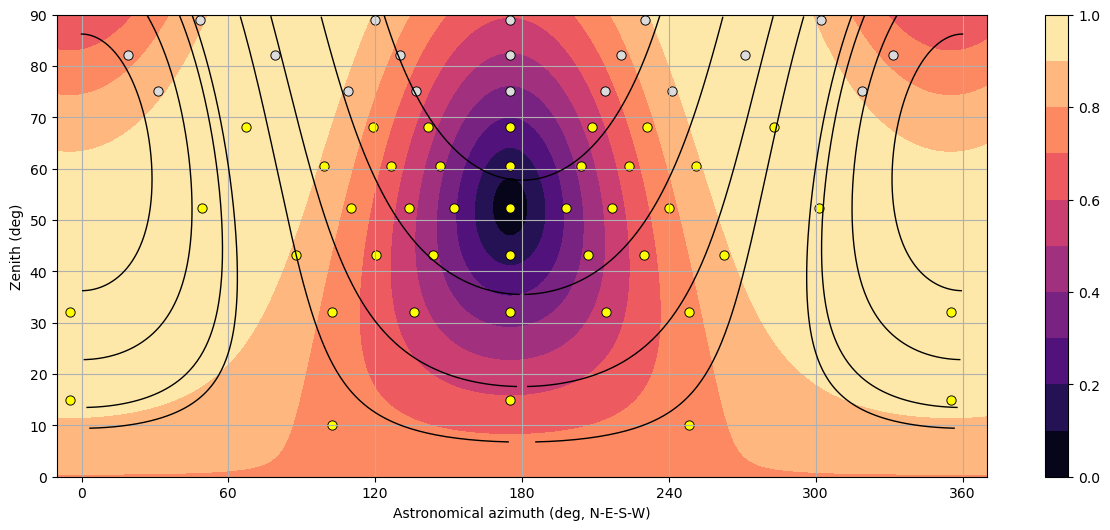

Total grid points (counting ~0/~360 only once): 59
Up to 70 deg: 40
70 to 80 deg: 7
Above 80 deg: 12


In [11]:
# x is azimuth w.r.t. North, measured EASTWARDS:
# y is zenith

# angular_separation needs altitudes instead of zeniths:
z = np.sin(angular_separation(az_bfield, 90*u.deg-zen_bfield, 
                              x*u.deg, 90*u.deg - y*u.deg))

plt.figure(figsize=(15,6))
plt.contourf(x, y, z, 10, cmap='magma')

plt.colorbar()
plt.xlabel('Astronomical azimuth (deg, N-E-S-W)')
plt.ylabel('Zenith (deg)')
plt.grid()
plt.xticks(ticks=np.linspace(0, 360, 7))


#dec_values = np.linspace(-40, 90, 14)
dec_values = np.array([])
# Add specific sources:
sources_dec = {'GC': -29, 
               'RS Oph': -6.75, 
               'PG 1553': 11.2, 
               'Crab': 22.014,
               'Mrk 421': 38.2,  
               'BL Lac': 42.25, 
               'LHAASO': 51.57,
               '1ES 1959': 65.0}

for source in sources_dec:
    dec_values= np.append(dec_values, sources_dec[source])


for source_dec in dec_values:
    src_az, src_zen, time = find_source_path(source_dec, 12, 90)
    plot_source_path(src_az, src_zen, time, 0.5)

 

grid_azs = np.array([])
grid_zds = np.array([])

for sindelta, coszd in zip(grid['sin_delta'], grid['cos_zenith']):
    
    zenith = np.rad2deg(np.arccos(coszd))
    
    azimuths = np.linspace(-10, 360, 370000)
    
    sindeltas = np.sin(angular_separation(az_bfield, 90*u.deg-zen_bfield, 
                                          azimuths*u.deg, 90*u.deg - zenith*u.deg))
    
    # find points in sindeltas which are closest to sindelta: 
    indices = argrelextrema(abs(sindeltas-sindelta), np.less)
    # print(zenith, abs(sindeltas-sindelta)[indices])
    # use only really close ones, otherwise we include azimuths which do not correspond
    # to the sin delta values in the file:
    mask = (abs(sindeltas-sindelta)[indices] < 1e-2)

    azimuth = azimuths[indices][mask]

    grid_azs = np.append(grid_azs, azimuth)
    grid_zds = np.append(grid_zds, [zenith]*len(azimuth))


# Solve "manually" the issue of rounding (i.e. "double points" close in az) for 
# south-pointing grid points:    
indices = np.argwhere(abs(grid_azs - np.mod(180+az_bfield.value, 360)) < 10)
grid_azs[indices] = np.mod(180+az_bfield.value,360)

# Same as above for north-pointing grid points:    
indices = np.argwhere(abs(grid_azs-(az_bfield.value)) < 15)
grid_azs[indices] = az_bfield.value
indices = np.argwhere(abs(grid_azs - (az_bfield.value-360)) < 15)
grid_azs[indices] = az_bfield.value - 360


# Remove point duplications:
for i in range(len(grid_zds)):
    a = grid_zds[i]
    b = grid_azs[i]
    
    if np.isnan(a):
        continue

    # print('{}: {:.2f}, {:.2f}'.format(i, a, b))

    dist = np.hypot(grid_zds-a, grid_azs-b)
    indices = np.argwhere(dist<1)[0]
    for j in indices:
        if j == i:
            continue
        # print("found duplication!")
        grid_zds[j] = np.nan
        grid_azs[j] = np.nan


print(np.isnan(grid_zds).sum(), 'duplications removed')

grid_zds = grid_zds[~np.isnan(grid_zds)]
grid_azs = grid_azs[~np.isnan(grid_azs)]

plt.scatter(grid_azs, grid_zds, color='black', s=40)
plt.scatter(grid_azs[grid_zds<70], grid_zds[grid_zds<70], color='yellow', s=25)
plt.scatter(grid_azs[grid_zds>70], grid_zds[grid_zds>70], color='gainsboro', s=25)

plt.show()
print('Total grid points (counting ~0/~360 only once):', len(grid_zds) - 2)
print('Up to 70 deg:', (grid_zds<70).sum() - 2)
print('70 to 80 deg:', ((grid_zds>=70) & (grid_zds<80)).sum())
print('Above 80 deg:', (grid_zds>=80).sum())


In [12]:
# For gammas, test:
min_energy_at_zenith = 0.005
max_energy_at_zenith = 50
top_energy = 200
energy_scaling_index = -2.5
max_impact_at_zenith = 700
impact_scaling_index = -1

max_viewcone = 0.4001
min_viewcone = 0.3999

print(' zen(deg)  az(deg)  cone_min(deg) cone_max(deg) max imp(m) Emin(TeV) Emax(TeV)')
for zd, az in zip(np.flip(grid_zds), np.flip(grid_azs)):
    if zd > 70:
        continue
    max_impact = max_impact_at_zenith*np.cos(np.deg2rad(zd))**impact_scaling_index
    min_E = min_energy_at_zenith*np.cos(np.deg2rad(zd))**energy_scaling_index
    max_E = min(top_energy, max_energy_at_zenith*np.cos(np.deg2rad(zd))**energy_scaling_index)

    print(f'{zd:8.3f}  {az:8.3f}  ',
          f'{min_viewcone:8.4f}     {max_viewcone:8.4f}   ',
          f'{max_impact:8.1f}  ',
          f'{min_E:8.3f}   {max_E:8.3f}')

 zen(deg)  az(deg)  cone_min(deg) cone_max(deg) max imp(m) Emin(TeV) Emax(TeV)
  10.000   248.117     0.3999       0.4001       710.8      0.005     51.951
  10.000   102.199     0.3999       0.4001       710.8      0.005     51.951
  14.984   355.158     0.3999       0.4001       724.6      0.005     54.516
  14.984    -4.842     0.3999       0.4001       724.6      0.005     54.516
  14.984   175.158     0.3999       0.4001       724.6      0.005     54.516
  32.059   355.158     0.3999       0.4001       826.0      0.008     75.617
  32.059    -4.842     0.3999       0.4001       826.0      0.008     75.617
  32.059   248.099     0.3999       0.4001       826.0      0.008     75.617
  32.059   102.217     0.3999       0.4001       826.0      0.008     75.617
  32.059   214.263     0.3999       0.4001       826.0      0.008     75.617
  32.059   136.053     0.3999       0.4001       826.0      0.008     75.617
  32.059   175.158     0.3999       0.4001       826.0      0.008     75.6

Number of different declinations: 30
total number of points: ~ 600

Declination: 68.01 degrees

 zen(deg)  az(deg)  cone_min(deg) cone_max(deg) max imp(m) Emin(TeV) Emax(TeV)
  61.752    25.065    0.000         2.500        1308.2      0.032    200.000
  58.213    25.281    0.000         2.500        1240.0      0.025    200.000
  54.687    24.850    0.000         2.500        1183.8      0.020    196.817
  51.264    23.696    0.000         2.500        1137.8      0.016    161.439
  48.048    21.743    0.000         2.500        1100.7      0.014    136.836
  45.152    18.930    0.000         2.500        1071.7      0.012    119.714
  42.703    15.236    0.000         2.500        1049.9      0.011    108.000
  40.829    10.718    0.000         2.500        1034.6      0.010    100.397
  39.649     5.543    0.000         2.500        1025.7      0.010     96.114
  39.245     0.000    0.000         2.500        1022.7      0.009     94.731
  39.649   354.457    0.000         2.500    

/tmp/ipykernel_27539/1334076653.py:9: RuntimeWarning: invalid value encountered in true_divide
  k = c / np.sin(c)


  65.165    32.530    0.000         2.500        1388.7      0.044    200.000
  60.632    33.528    0.000         2.500        1285.2      0.030    200.000
  56.019    33.823    0.000         2.500        1203.8      0.021    200.000
  51.419    33.301    0.000         2.500        1139.7      0.016    162.809
  46.940    31.809    0.000         2.500        1089.2      0.013    129.805
  42.714    29.160    0.000         2.500        1050.0      0.011    108.050
  38.909    25.149    0.000         2.500        1020.3      0.009     93.609
  35.731    19.614    0.000         2.500         998.9      0.008     84.214
  33.414    12.565    0.000         2.500         985.1      0.008     78.547
  32.184     4.339    0.000         2.500         978.3      0.008     75.876
  32.184   355.661    0.000         2.500         978.3      0.008     75.876
  33.414   347.435    0.000         2.500         985.1      0.008     78.547
  35.731   340.386    0.000         2.500         998.9      0.0

  12.829    58.737    0.000         2.500         911.4      0.005     53.262
   7.093    31.090    0.000         2.500         903.5      0.005     50.970
   7.093   328.910    0.000         2.500         903.5      0.005     50.970
  12.829   301.263    0.000         2.500         911.4      0.005     53.262
  19.807   293.294    0.000         2.500         927.9      0.006     58.235
  27.055   290.810    0.000         2.500         953.7      0.007     66.804
  34.367   290.463    0.000         2.500         990.6      0.008     80.770
  41.666   291.198    0.000         2.500        1041.3      0.010    103.662
  48.911   292.603    0.000         2.500        1110.2      0.014    142.784
  56.069   294.498    0.000         2.500        1204.6      0.021    200.000
  63.108   296.803    0.000         2.500        1338.2      0.036    200.000
  69.992   299.495    0.000         2.500        1538.6      0.073    200.000

Declination: 22.76 degrees

 zen(deg)  az(deg)  cone_min(deg) c

  66.940   107.713    0.000         2.500        1438.0      0.052    200.000
  61.315   111.984    0.000         2.500        1299.1      0.031    200.000
  55.869   116.778    0.000         2.500        1201.5      0.021    200.000
  50.664   122.264    0.000         2.500        1130.4      0.016    156.306
  45.791   128.650    0.000         2.500        1077.8      0.012    123.156
  41.372   136.177    0.000         2.500        1038.9      0.010    102.492
  37.573   145.082    0.000         2.500        1010.9      0.009     89.406
  34.602   155.502    0.000         2.500         992.0      0.008     81.343
  32.689   167.317    0.000         2.500         981.0      0.008     76.947
  32.026   180.000    0.000         2.500         977.4      0.008     75.549
  32.689   192.683    0.000         2.500         981.0      0.008     76.947
  34.602   204.498    0.000         2.500         992.0      0.008     81.343
  37.573   214.918    0.000         2.500        1010.9      0.0

  69.960   126.060    0.000         2.500        1537.5      0.073    200.000
  66.086   129.984    0.000         2.500        1413.6      0.048    200.000
  62.439   134.275    0.000         2.500        1323.1      0.034    200.000
  59.062   138.978    0.000         2.500        1255.2      0.026    200.000
  56.003   144.129    0.000         2.500        1203.6      0.021    200.000
  53.319   149.753    0.000         2.500        1164.5      0.018    181.297
  51.070   155.849    0.000         2.500        1135.4      0.016    159.750
  49.316   162.380    0.000         2.500        1114.7      0.015    145.725
  48.111   169.269    0.000         2.500        1101.4      0.014    137.254
  47.496   176.395    0.000         2.500        1094.9      0.013    133.255
  47.496   183.605    0.000         2.500        1094.9      0.013    133.255
  48.111   190.731    0.000         2.500        1101.4      0.014    137.254
  49.316   197.620    0.000         2.500        1114.7      0.0

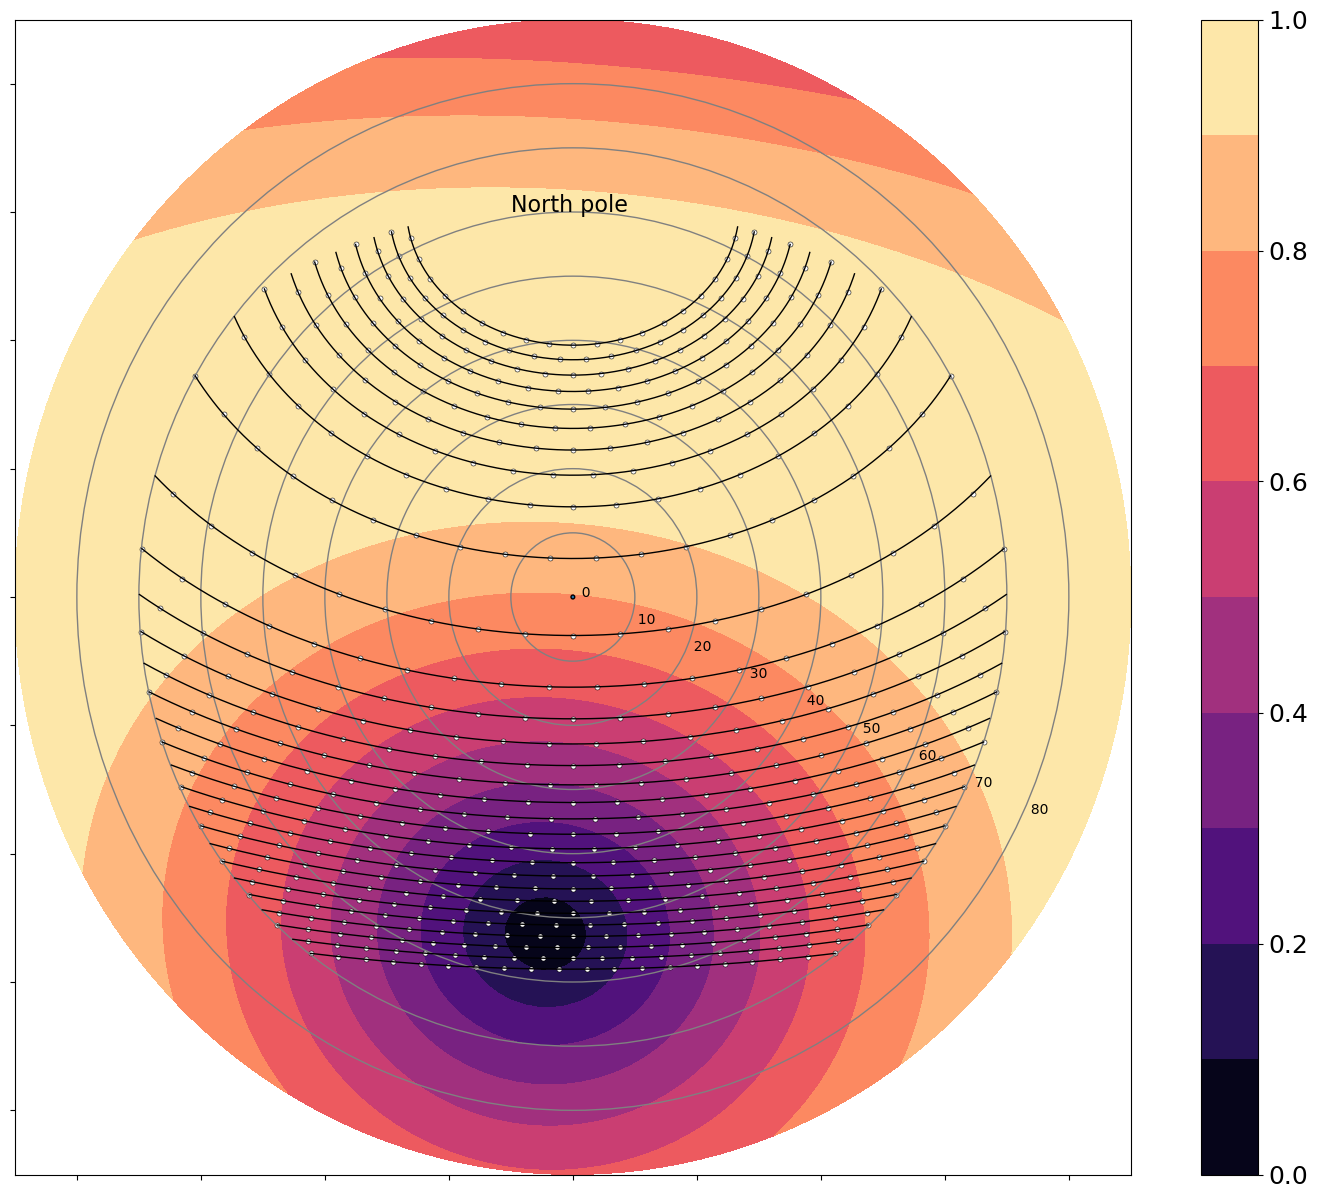

In [13]:
selected_declination = None
# selected_declination = 22.7636

plt.figure(figsize=(18,15))

xx, yy = zd_az_to_azimuthal_equidistant(y, x)
plt.contourf(xx, yy, z, 10, cmap='magma')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=18)

min_zenith_at_culmination = 6*u.deg
max_zenith_at_culmination = 58*u.deg
min_cos = np.cos(max_zenith_at_culmination)
max_cos = np.cos(min_zenith_at_culmination)

n_dec_values = 20  # on each side of the site's latitude, but may be fewer in the end because of the max_dec cut
n_time_values = 20
max_dec = 70*u.deg

culmination_cos_zenith = np.linspace(max_cos, min_cos, n_dec_values)
culmination_zenith = np.arccos(culmination_cos_zenith)

dec_south = LP_lat - culmination_zenith
dec_north = LP_lat + culmination_zenith
dec = np.append(np.flip(dec_north), dec_south)
# Limit the declination range:
dec = dec[dec<max_dec]
print("Number of different declinations:", len(dec))
print("total number of points: ~", len(dec)*n_time_values)


# For protons, training:
"""
max_view_cone_at_zenith = 8
view_cone_scaling_index = 0.5
min_energy_at_zenith = 0.01
max_energy_at_zenith = 100
top_energy = 200
energy_scaling_index = -2.5
max_impact_at_zenith = 1500
impact_scaling_index = -0.5
"""

# For gammas, training:
max_view_cone_at_zenith = 2.5
view_cone_scaling_index = 0
min_energy_at_zenith = 0.005
max_energy_at_zenith = 50
top_energy = 200
energy_scaling_index = -2.5
max_impact_at_zenith = 900
impact_scaling_index = -0.5

for i, d in enumerate(dec.value):
    
    if selected_declination is not None and not np.isclose(d, selected_declination):
        continue

    print()
    print(f'Declination: {d:.2f} degrees')
    print()
    print(' zen(deg)  az(deg)  cone_min(deg) cone_max(deg) max imp(m) Emin(TeV) Emax(TeV)')
    src_az, src_zen, time = find_source_path(d, 6, 70)
    plot_source_path(src_az, src_zen, time, np.nan, True)
    
    grid_times = np.linspace(time.min(), time.max(), n_time_values)
    
    
    interp_az_vs_t = interp1d(time, src_az, fill_value="extrapolate")
    interp_zen_vs_t = interp1d(time, src_zen, fill_value="extrapolate")
    if i%2 == 0:
        # shift by half the time step, then remove point to keep within t-range:
        grid_times += 0.5*(time.max() - time.min()) / (n_time_values-1)
        grid_times = grid_times[:-1]
    
    src_az_2 = interp_az_vs_t(grid_times)
    src_zen_2 = interp_zen_vs_t(grid_times)
    srcx, srcy = zd_az_to_azimuthal_equidistant(np.array(src_zen_2), np.array(src_az_2))
    plt.scatter(srcx, srcy, color='black', s=9)
    plt.scatter(srcx, srcy, color='white', s=5)
    
    for i, zd in enumerate(src_zen_2):
        max_viewcone = max_view_cone_at_zenith*np.cos(np.deg2rad(zd))**view_cone_scaling_index
        min_viewcone = 0
        max_impact = max_impact_at_zenith*np.cos(np.deg2rad(zd))**impact_scaling_index
        min_E = min_energy_at_zenith*np.cos(np.deg2rad(zd))**energy_scaling_index
        max_E = min(top_energy, max_energy_at_zenith*np.cos(np.deg2rad(zd))**energy_scaling_index)

        print(f'{zd:8.3f}  {src_az_2[i]:8.3f}',
              f'{min_viewcone:8.3f}      {max_viewcone:8.3f}     ',
              f'{max_impact:8.1f}  ',
              f'{min_E:8.3f}   {max_E:8.3f}')

circle = plt.Circle((0,0), 0.3, fill=True, edgecolor='black')
plt.gca().add_patch(circle)
for R in np.linspace(0, 80, 9):
    circle = plt.Circle((0,0), R, fill=False, edgecolor='grey')
    plt.gca().add_patch(circle)
    plt.text(R*np.cos(np.deg2rad(-25)), R*np.sin(np.deg2rad(-25)), f'  {int(R)}')

plt.text(-10, 60, 'North pole', fontsize=16)

plt.gca().axes.xaxis.set_ticklabels([])
plt.gca().axes.yaxis.set_ticklabels([])
plt.xlim(-90, 90)
plt.ylim(-90, 90)


plt.show()

/tmp/ipykernel_27539/1334076653.py:9: RuntimeWarning: invalid value encountered in true_divide
  k = c / np.sin(c)


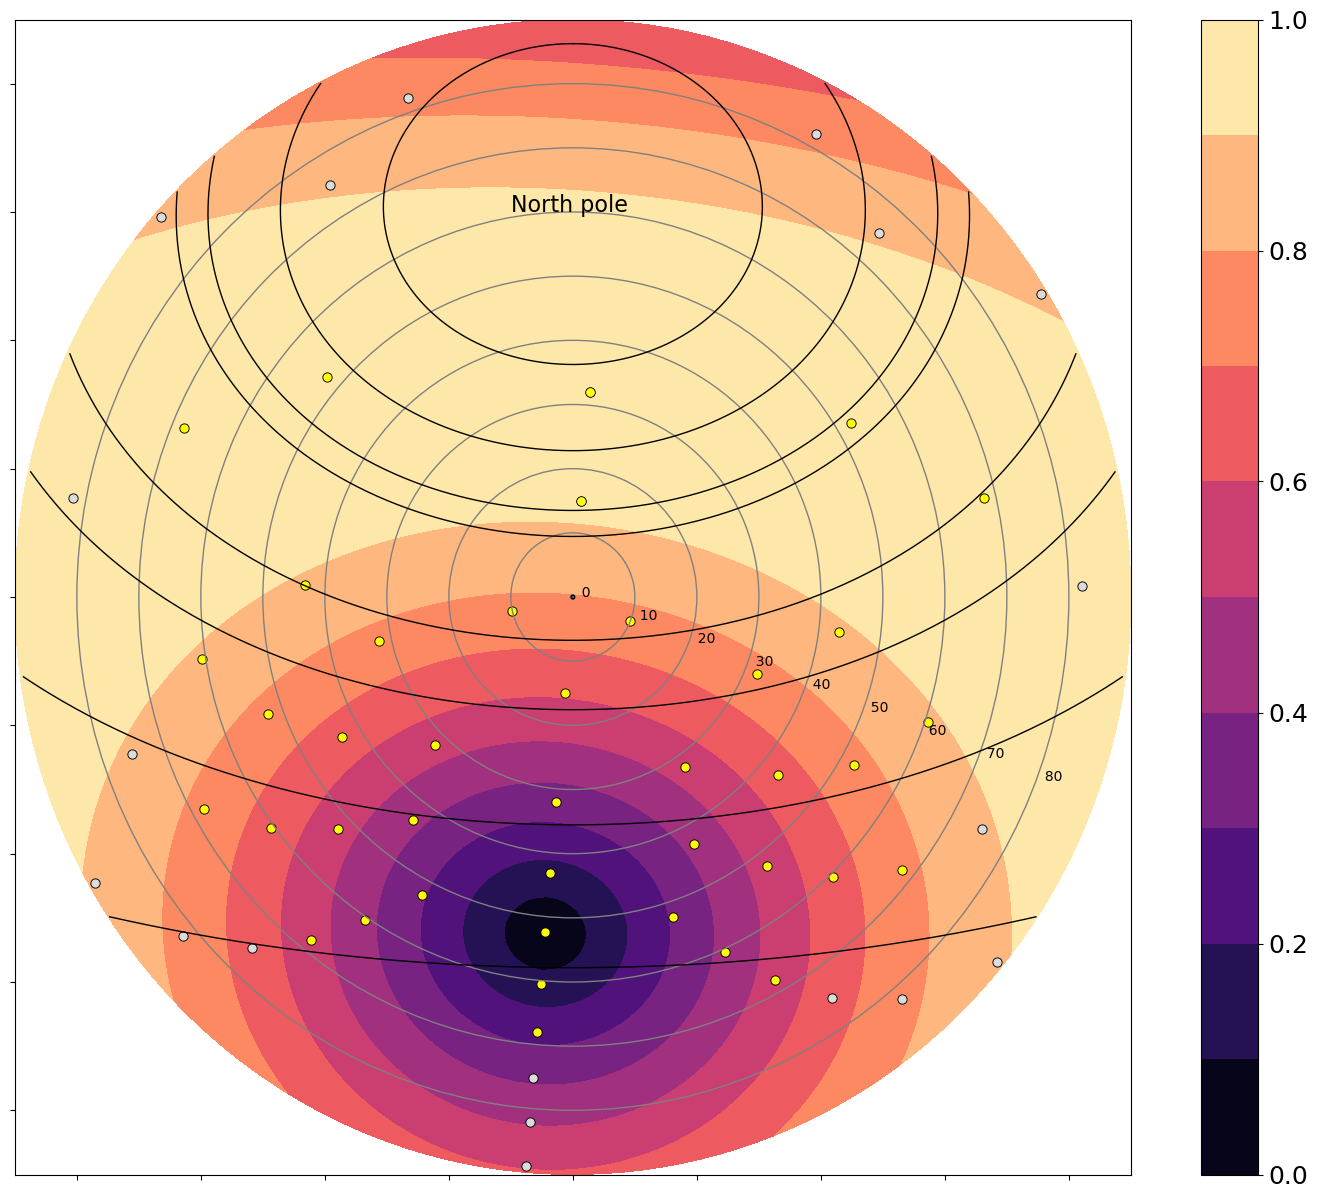

In [14]:
plt.figure(figsize=(18,15))

xx, yy = zd_az_to_azimuthal_equidistant(y, x)
plt.contourf(xx, yy, z, 10, cmap='magma')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=18)

for source_dec in dec_values:
    src_az, src_zen, time = find_source_path(source_dec, 12, 90)
    plot_source_path(src_az, src_zen, time, 0.5, True)

xx, yy = zd_az_to_azimuthal_equidistant(grid_zds[grid_zds<70], grid_azs[grid_zds<70])
plt.scatter(xx, yy, color='black', s=40)
plt.scatter(xx, yy, color='yellow', s=25)
xx, yy = zd_az_to_azimuthal_equidistant(grid_zds[grid_zds>70], grid_azs[grid_zds>70])
plt.scatter(xx, yy, color='black', s=40)
plt.scatter(xx, yy, color='gainsboro', s=25)

circle = plt.Circle((0,0), 0.3, fill=True, edgecolor='black')
plt.gca().add_patch(circle)
for R in np.linspace(0, 80, 9):
    circle = plt.Circle((0,0), R, fill=False, edgecolor='grey')
    plt.gca().add_patch(circle)
    plt.text(R*np.cos(np.deg2rad(-21)), R*np.sin(np.deg2rad(-21)), f'  {int(R)}')

plt.text(-10, 60, 'North pole', fontsize=16)

plt.gca().axes.xaxis.set_ticklabels([])
plt.gca().axes.yaxis.set_ticklabels([])
plt.xlim(-90, 90)
plt.ylim(-90, 90)


plt.show()

In [15]:
plt.rcParams['font.size'] = 15

/tmp/ipykernel_27539/1334076653.py:9: RuntimeWarning: invalid value encountered in true_divide
  k = c / np.sin(c)
/tmp/ipykernel_27539/4189082508.py:27: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((0,0), 0.3, fill=True, color='k', edgecolor='k')
/tmp/ipykernel_27539/4189082508.py:30: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((0,0), 90, fill=False, color='k', edgecolor='k',)


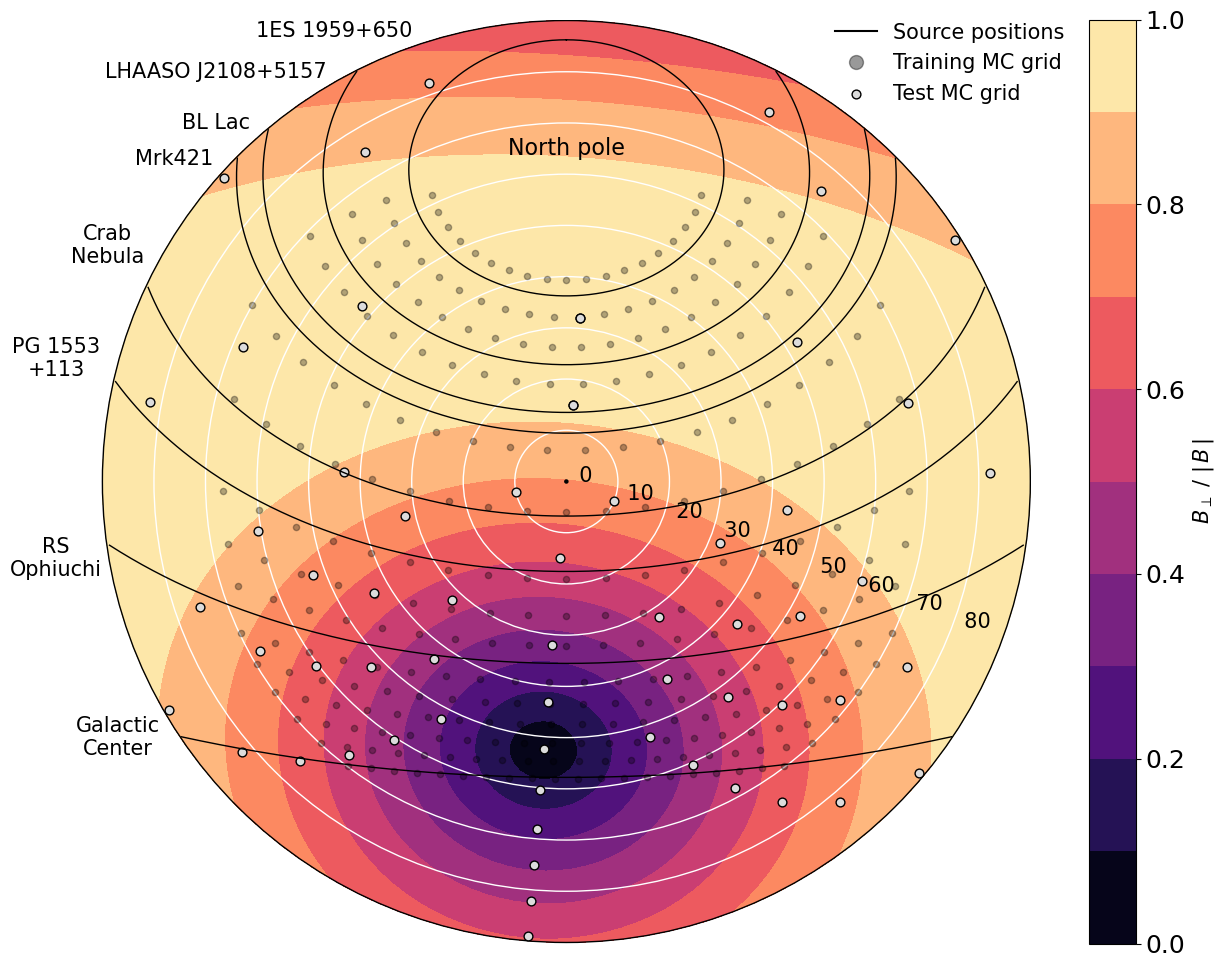

In [18]:
c1 = 'k'
edgec = 'w'
cmap = 'magma'
selected_declination = None

plt.figure(figsize=(15,12))

xx, yy = zd_az_to_azimuthal_equidistant(y, x)
plt.contourf(xx, yy, z, 10, cmap=cmap, zorder=-12)
cbar = plt.colorbar(label='$B_{\perp} \ / \ \\left | \\, B \\, \\right |$')
cbar.ax.tick_params(labelsize=18)


ios = [0, 1, 2, 3, 4, 5, 6, 7]
for i, source_dec in enumerate(dec_values):
    
    if i in ios:
        src_az, src_zen, time = find_source_path(source_dec, 12, 90)
        plot_source_path(src_az, src_zen, time, 0.5, True)

# xx, yy = zd_az_to_azimuthal_equidistant(grid_zds[grid_zds<70], grid_azs[grid_zds<70])
# plt.scatter(xx, yy, color=color1, s=40, edgecolors=edgec)

# xx, yy = zd_az_to_azimuthal_equidistant(grid_zds[grid_zds>70], grid_azs[grid_zds>70])
# plt.scatter(xx, yy, color=color2, s=25, edgecolors=edgec)

circle = plt.Circle((0,0), 0.3, fill=True, color='k', edgecolor='k')
plt.gca().add_patch(circle)

circle = plt.Circle((0,0), 90, fill=False, color='k', edgecolor='k',)
plt.gca().add_patch(circle)

for R in np.linspace(0, 80, 9):
    circle = plt.Circle((0,0), R, fill=False, edgecolor='w', zorder=-10)
    plt.gca().add_patch(circle)
    plt.text(R*np.cos(np.deg2rad(-21)), R*np.sin(np.deg2rad(-21)), f'  {int(R)}')

plt.text(0, 65, 'North pole', fontsize=16, ha='center', va='center')

plt.gca().axes.xaxis.set_ticklabels([])
plt.gca().axes.yaxis.set_ticklabels([])
plt.xlim(-90.2, 90.2)
plt.ylim(-90.2, 90.2)
plt.axis('off')

ies = [0, 3, 5, 7, 9, 10, 12, 14, 16, 19,
       21, 23, 25,  27, 29]

for i, d in enumerate(dec.value):
    
    if i in ies:
    
        if selected_declination is not None and not np.isclose(d, selected_declination):
            continue

        src_az, src_zen, time = find_source_path(d, 6, 70)
#         plot_source_path2(src_az, src_zen, time, np.nan, True)

        grid_times = np.linspace(time.min(), time.max(), n_time_values)


        interp_az_vs_t = interp1d(time, src_az, fill_value="extrapolate")
        interp_zen_vs_t = interp1d(time, src_zen, fill_value="extrapolate")
        if i%2 == 0:
            # shift by half the time step, then remove point to keep within t-range:
            grid_times += 0.5*(time.max() - time.min()) / (n_time_values-1)
            grid_times = grid_times[:-1]

        src_az_2 = interp_az_vs_t(grid_times)
        src_zen_2 = interp_zen_vs_t(grid_times)
        srcx, srcy = zd_az_to_azimuthal_equidistant(np.array(src_zen_2), np.array(src_az_2))

        plt.scatter(srcx, srcy, color=c1, s=20, marker='o', alpha=0.3)

        for i, zd in enumerate(src_zen_2):
            max_viewcone = max_view_cone_at_zenith*np.cos(np.deg2rad(zd))**view_cone_scaling_index
            min_viewcone = 0
            max_impact = max_impact_at_zenith*np.cos(np.deg2rad(zd))**impact_scaling_index
            min_E = min_energy_at_zenith*np.cos(np.deg2rad(zd))**energy_scaling_index
            max_E = min(top_energy, max_energy_at_zenith*np.cos(np.deg2rad(zd))**energy_scaling_index)
        

plt.plot([], [], marker='', ls='-', color='k', ms=10, label='Source positions')
plt.plot([], [], marker='o', ls='', color='k', ms=10, alpha=0.4, label='Training MC grid')
plt.scatter([], [], marker='o', color='gainsboro', edgecolor='black', s=40, label='Test MC grid')
plt.legend(loc=(.78,.9), frameon=False)

plt.text(-45,88, '1ES 1959+650', ha='center', va='center')
plt.text(-68,80, 'LHAASO J2108+5157', ha='center', va='center')
plt.text(-68,70, 'BL Lac', ha='center', va='center')
plt.text(-76,63, 'Mrk421', ha='center', va='center')
plt.text(-89,46, 'Crab\nNebula', ha='center', va='center')
plt.text(-99,24, 'PG 1553\n+113', ha='center', va='center')
plt.text(-99,-15, 'RS\nOphiuchi', ha='center', va='center')
plt.text(-87,-50, 'Galactic\nCenter', ha='center', va='center')

xx, yy = zd_az_to_azimuthal_equidistant(grid_zds[grid_zds<70], grid_azs[grid_zds<70])
plt.scatter(xx, yy, color='gainsboro', edgecolor='black', s=40)
xx, yy = zd_az_to_azimuthal_equidistant(grid_zds[grid_zds>70], grid_azs[grid_zds>70])
plt.scatter(xx, yy, color='gainsboro', edgecolor='black', s=40)




pltpath = 'plots/'
dpi = 300
plt.savefig(f'{pltpath}mc-pointings.pdf', bbox_inches='tight', dpi=dpi)
plt.show()

Relative to center:
[-6.33607046 60.40543812  0.60828365]
[ 41.05392954 -79.27456188  -1.14171635]
[-2.94560705e+01 -3.12945619e+01  2.82836495e-02]

With y towards geographic North, x towards geographic East:
M1 w.r.t. M1_M2_center: 23.99000000000001 35.255
M2 w.r.t. M1_M2_center: -23.98999999999998 -35.254999999999995
LST1 w.r.t. M1_M2_center: -115.69 -12.135000000000005


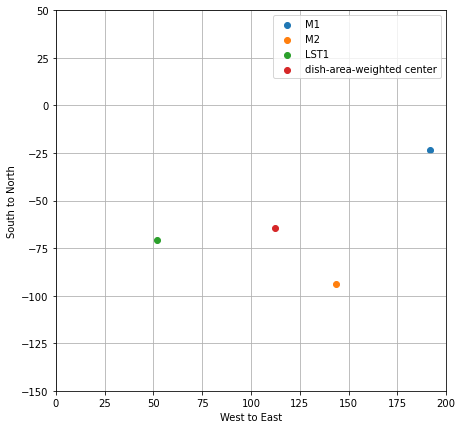

In [15]:
# Telescope coordinates (cm) as used in our current LST1 simulations (x=geographic N, y=geo W)
#
# LST1  TELESCOPE     -70.930E2    -52.070E2   43.00E2   
# MAGIC1 TELESCOPE     -23.540E2    -191.750E2   41.25E2
# MAGIC2 TELESCOPE     -94.050E2    -143.770E2   42.42E2
# Taken from input card with geographic north towards PHIP -5.3195 (i.e.  5.3195 degrees towards EAST of magnetic north)

LST1_location = np.array([-70.93, -52.07, 43.])
M1_location = np.array([-23.54, -191.75, 41.25])
M2_location = np.array([-94.05, -143.77, 42.42])


wL1 = 23**2
wM1 = 17**2
wM2 = 17**2
middle_point = (wL1*LST1_location + wM1*M1_location + wM2*M2_location)/ (wL1 + wM1 + wM2)

print('Relative to center:')
for x in [LST1_location, M1_location, M2_location]:
    print(x - middle_point)
print()


plt.figure(figsize=(7, 7))

print("With y towards geographic North, x towards geographic East:")
M1_M2_center = 0.5 * (M1_location + M2_location)

print('M1 w.r.t. M1_M2_center:', 
      -M1_location[1] + M1_M2_center[1],
      M1_location[0] - M1_M2_center[0])

print('M2 w.r.t. M1_M2_center:', 
      -M2_location[1] + M1_M2_center[1],
      M2_location[0] - M1_M2_center[0])

print('LST1 w.r.t. M1_M2_center:', 
      -LST1_location[1] + M1_M2_center[1],
      LST1_location[0] - M1_M2_center[0])


# With y=North, x=East:
M1_xyz = np.array([-M1_location[1], M1_location[0], M1_location[2]])
M2_xyz = np.array([-M2_location[1], M2_location[0], M2_location[2]])
LST1_xyz = np.array([-LST1_location[1], LST1_location[0], LST1_location[2]])

plt.scatter(M1_xyz[0], M1_xyz[1], label='M1')
plt.scatter(M2_xyz[0], M2_xyz[1], label='M2')
plt.scatter(LST1_xyz[0], LST1_xyz[1], label='LST1')


plt.scatter(-middle_point[1], middle_point[0], label='dish-area-weighted center')
plt.legend()
plt.grid()
plt.xlim(0, 200)
plt.ylim(-150, 50)
plt.xlabel('West to East')
plt.ylabel('South to North')
plt.show()

In [16]:
# How we would see the array from direction az, zen (astronomical coordinates)
# We rotate the vectors of the telescope positions.

M1_M2_dist = []
LST1_M2_dist = []
LST1_M1_dist = []
x, y = np.meshgrid(np.linspace(-10,370,190), np.linspace(0,75,150))
for az, zen in zip(x.flatten(), y.flatten()):
    axis_versor = np.array([-np.cos(np.deg2rad(az)), np.sin(np.deg2rad(az)), 0])
    R = Rotation.from_rotvec(zen * axis_versor, degrees=True)
    M1_rotated = R.apply(M1_xyz)
    M2_rotated = R.apply(M2_xyz)
    LST1_rotated = R.apply(LST1_xyz)
    # Calculate distance between LST1 and M2 on the orthogonal plane
    diff = LST1_rotated - M2_rotated
    LST1_M2_dist.append(np.hypot(diff[0], diff[1]))
    diff = LST1_rotated - M1_rotated
    LST1_M1_dist.append(np.hypot(diff[0], diff[1]))
    diff = M1_rotated - M2_rotated
    M1_M2_dist.append(np.hypot(diff[0], diff[1]))

M1_M2_dist = np.reshape(M1_M2_dist, x.shape)
LST1_M2_dist = np.reshape(LST1_M2_dist, x.shape)
LST1_M1_dist = np.reshape(LST1_M1_dist, x.shape)

Minimum inter-telescope distance (m):


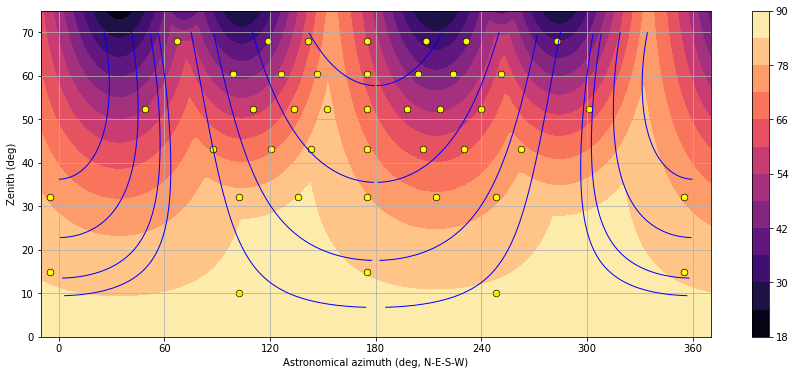

In [17]:
min_dist = np.minimum(M1_M2_dist, LST1_M2_dist)
min_dist = np.minimum(min_dist, LST1_M1_dist)

plt.figure(figsize=(15,6))
plt.contourf(x, y, min_dist, 10, cmap='magma')

plt.colorbar()
plt.xlabel('Astronomical azimuth (deg, N-E-S-W)')
plt.ylabel('Zenith (deg)')
plt.grid()
plt.xticks(ticks=np.linspace(0, 360, 7))

plt.scatter(grid_azs[grid_zds<70], grid_zds[grid_zds<70], color='black', s=40)
plt.scatter(grid_azs[grid_zds<70], grid_zds[grid_zds<70], color='yellow', s=25)

for source_dec in dec_values:
    src_az, src_zen, time = find_source_path(source_dec, 12, 90)
    plot_source_path(src_az[src_zen<70], src_zen[src_zen<70], time[src_zen<70], np.nan)

print("Minimum inter-telescope distance (m):")
plt.show()

Maximum inter-telescope distance (m):


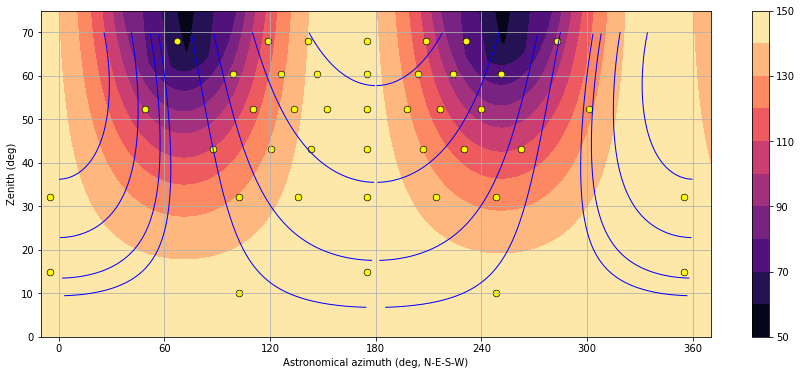

In [18]:
max_dist = np.maximum(M1_M2_dist, LST1_M2_dist)
max_dist = np.maximum(max_dist, LST1_M1_dist)

plt.figure(figsize=(15,6))
plt.contourf(x, y, max_dist, 10, cmap='magma')

plt.colorbar()
plt.xlabel('Astronomical azimuth (deg, N-E-S-W)')
plt.ylabel('Zenith (deg)')
plt.grid()
plt.xticks(ticks=np.linspace(0, 360, 7))

plt.scatter(grid_azs[grid_zds<70], grid_zds[grid_zds<70], color='black', s=40)
plt.scatter(grid_azs[grid_zds<70], grid_zds[grid_zds<70], color='yellow', s=25)

for source_dec in dec_values:
    src_az, src_zen, time = find_source_path(source_dec, 12, 90)
    plot_source_path(src_az[src_zen<70], src_zen[src_zen<70], time[src_zen<70], np.nan)

print("Maximum inter-telescope distance (m):")
plt.show()